In [2]:
## Alibi-Detect Module Install ##
!pip install alibi_detect

## Image Pre-Processing ##
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image

img_list = glob('C:/Users/user/Downloads/capsule.tar/capsule/capsule/train/good/*.png') # normal 이미지

train_img_list, val_img_list = train_test_split(img_list, test_size=0.1, random_state=2021)
print(len(train_img_list), len(val_img_list))

def img_to_np(fpaths, resize=True):
  img_array = []
  for fname in fpaths:
    try:
      img = Image.open(fname).convert('RGB')
      if resize:
        img = img.resize((64,64)) # 64x64 size 변환!
        img_array.append(np.asarray(img)) # numpy 배열 변환
    except:
      continue  # try 문에서 해당되지 않으면 넘김!

  images = np.array(img_array)
  return images

197 22


In [3]:
# train 197장, val 22장 Normalize
x_train = img_to_np(train_img_list[:197])
x_train = x_train.astype(np.float32) / 255. # normalize

x_val = img_to_np(val_img_list[:22])
x_val = x_val.astype(np.float32) / 255.

print(x_train.shape)
print(x_val.shape)

(197, 64, 64, 3)
(22, 64, 64, 3)


In [4]:
## Reconstruction 이미지를 생성하는 Auto-Encoder 학습 ##
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from alibi_detect.od import OutlierVAE
latent_dim = 1024

encoder_net = tf.keras.Sequential([
                                   InputLayer(input_shape=(64,64,3)),
                                   Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
                                   Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
                                   Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
])

# decoder의 input은 latent vector 크기로 들어간다는 점!
# covloution transpose 과정은 차원을 늘리는 과정
# deconv 과정을 거치면 결국 input size와 같은 64x64x3 의 size로 나옴.
decoder_net = tf.keras.Sequential([
                                   InputLayer(input_shape=(latent_dim, )),
                                   Dense(4 * 4 * 128),
                                   Reshape(target_shape=(4, 4, 128)), # convolution transepose 하기 위해
                                   Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
                                   Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
                                   Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
                                   Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
])

outlier = OutlierVAE(
    threshold=.005, # instance(픽셀의 차) score 
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim
)

In [5]:
# 정상데이터만을 넣어서 Recontruction 이미지를 만들어냄
outlier.fit(
    x_train,
    epochs=30,
    verbose=True  # '학습 결과를 출력해라'
)

4/4 [=] - 2s 540ms/step - loss: -23039.7046


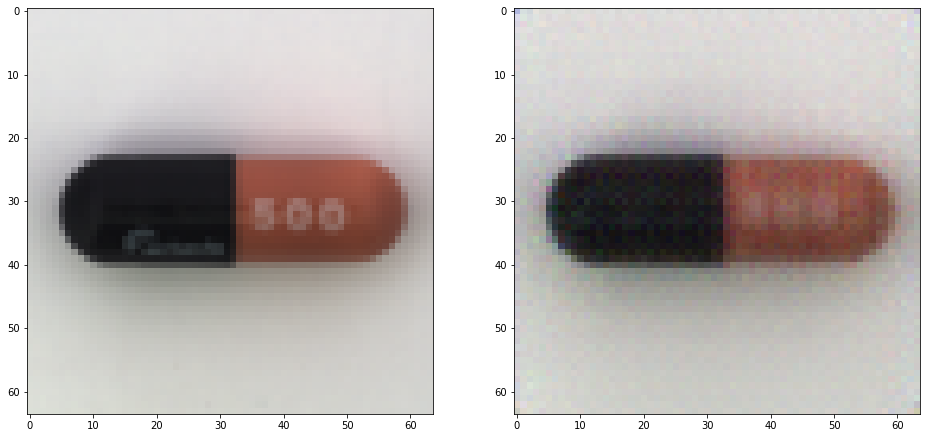

In [6]:
# 원본 train 이미지
x = x_train[0].reshape(1, 64, 64, 3)

# Reconstrution 이미지
x_reconst = outlier.vae(x).numpy()

# imshow
fig, axes = plt.subplots(1, 2, figsize=(16,10)) # 1행 2열의 도표 생성!
axes[0].imshow(x.squeeze())
axes[1].imshow(x_reconst.squeeze())

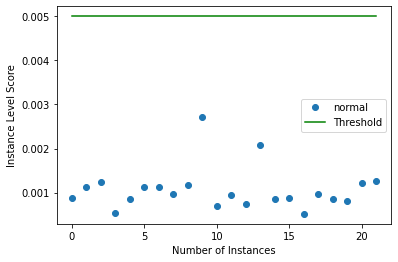

In [7]:
## Normal 데이터 Test 과정(Validation) ##
# 정상데이터로만 학습하여 생성한 인코더가 재생성 이미지를 잘만들어 내는지를 확인하는 과정
# Alibi Detect 모듈을 통해 그래프를 그릴수 있음
# 그래프의 파란색 점은 각 validation score를 표시한 것 (현재는 32개의 점)
# 그래서 threshold 보다 아래쪽에 있으면 normal 데이터임을 나타냄
# 픽셀간의 차를 나타낸 instance score

from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
# 정상데이터로만 생성한 encoder가 재생성 이미지를 잘만들어내는지?
outlier_preds = outlier.predict(
    x_val,
    outlier_type='instance', # 픽셀 간의 차(instance)
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_val.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(outlier_preds, target, labels, outlier.threshold)

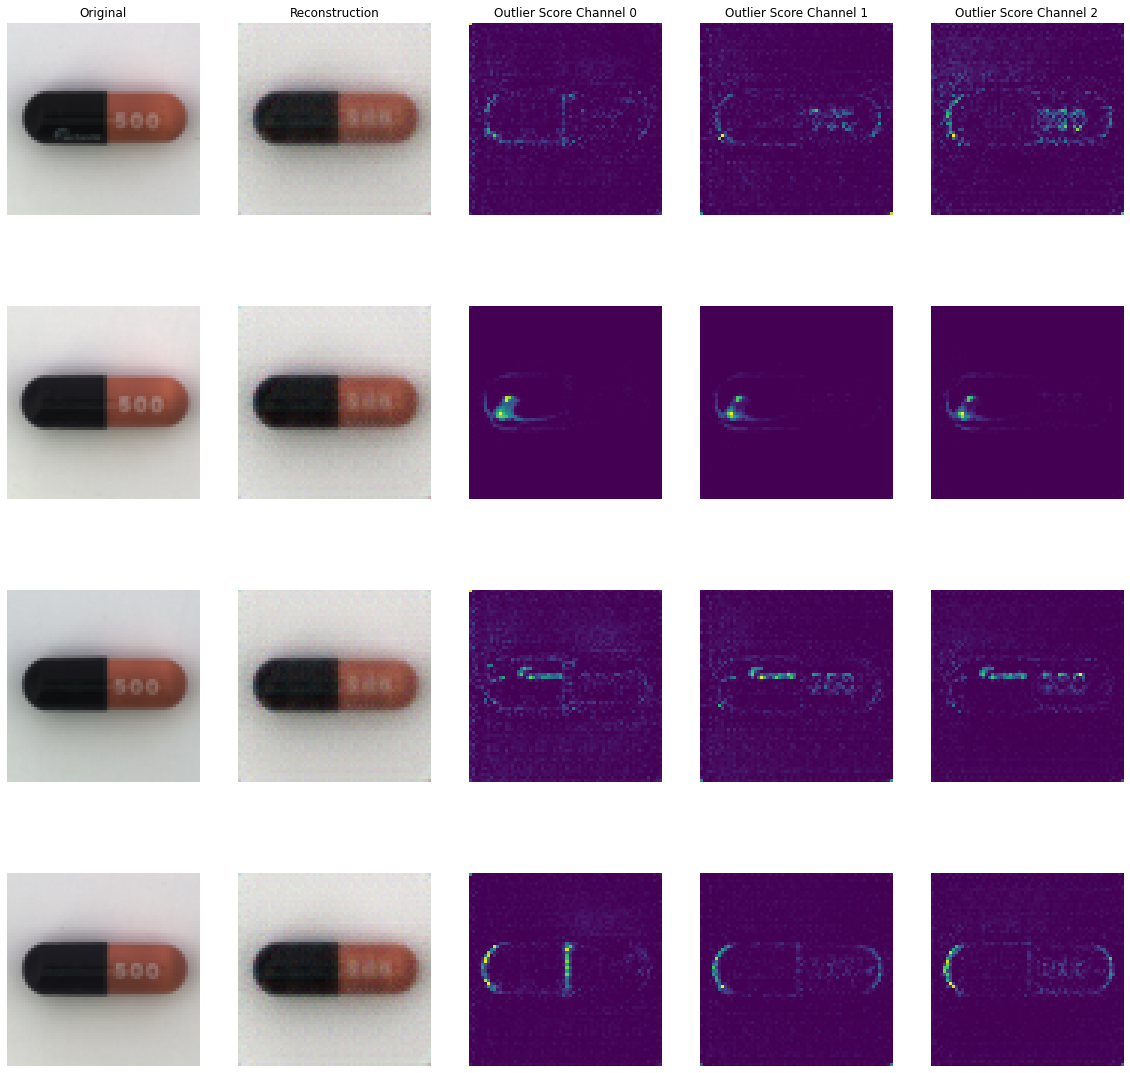

In [15]:
# outlier score channel 표시된 부분은 Original과 Reconstructions 부분의 차를 뺸 것

x_recon = outlier.vae(x_val).numpy()

plot_feature_outlier_image(
    outlier_preds,
    x_val,
    X_recon=x_recon,
    max_instances=4,
    outliers_only=False  # outliers_only=True는 위에서 그린 그래프에서 Threshold 벗어난 그림
)

In [24]:
## Crack 데이터 Test 과정 ##
# Crack 데이터와 재생성한 이미지의 차이를 구함 #
# Crack의 Feature를 얻는 과정 #
test_img_list = glob('C:/Users/user/Downloads/capsule.tar/capsule/capsule/test/crack/*.png')

x_test = img_to_np(test_img_list[:23])
x_test = x_test.astype(np.float32) / 255.

print(x_test.shape)

(23, 64, 64, 3)


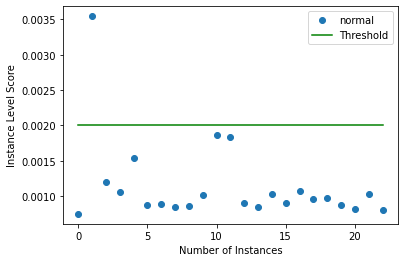

In [13]:
outlier_preds = outlier.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_test.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(outlier_preds, target, labels, outlier.threshold)

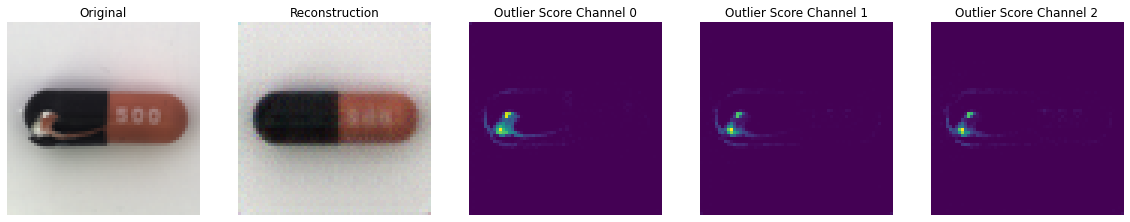

In [17]:
# instance score가 threshold 를 벗어난 그림들을 표현한 것!
x_reconst = outlier.vae(x_test).numpy()

plot_feature_outlier_image(
    outlier_preds,
    x_test,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=True
)

In [18]:
## threshold를 0.005로 잡았더니, cracked 이미지를 1개밖에 찾아내지 못했다.